<a href="https://colab.research.google.com/github/RizkyWidodo-project/EJ-EONC_Project/blob/main/K_Means_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up Environment

In [ ]:
# Install Packages
!pip install geopandas pandas pyproj shapely fiona scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 41.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


#Mount Google Drive and Access file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 1. Load population points
points_df = pd.read_csv('file_path')

# 2. Calculate centroid coordinates
points_df['x'] = (points_df['left'] + points_df['right']) / 2
points_df['y'] = (points_df['top'] + points_df['bottom']) / 2

# 3. Create geometry from centroid coordinates
points_gdf = gpd.GeoDataFrame(
    points_df,
    geometry=gpd.points_from_xy(points_df['x'], points_df['y']),
    crs="EPSG:4326"
)

# 4. Rename population and cell ID fields for consistency
points_gdf = points_gdf.rename(columns={'VALUE': 'value', 'id': 'cell_id'})

# 5. Project to a metric CRS for accurate clustering (use UTM zone for Java)
projected_crs = "EPSG:32748"
points_gdf = points_gdf.to_crs(projected_crs)

#6. Print CSV
print(points_df.columns)

<ipython-input-4-319670b63e52>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  points_df = pd.read_csv('/content/drive/MyDrive/MAP5010 Research Project/Population Point_Grid_Location.csv')


Index(['VALUE', 'id', 'left', 'top', 'right', 'bottom', 'row_index',
       'col_index', 'OBJECTID', 'NAMOBJ', 'FCODE', 'REMARK', 'METADATA',
       'SRS_ID', 'KDBBPS', 'KDCBPS', 'KDCPUM', 'KDEBPS', 'KDEPUM', 'KDPBPS',
       'KDPKAB', 'KDPPUM', 'LUASWH', 'TIPADM', 'WADMKC', 'WADMKD', 'WADMKK',
       'WADMPR', 'WIADKC', 'WIADKK', 'WIADPR', 'WIADKD', 'UUPP',
       'Shape_Length', 'Shape_Area', 'x', 'y'],
      dtype='object')


#K-Means Clustering

In [ ]:
# 6. K-means clustering with dynamic k and population weights
cluster_centroids = []

for cell_id, group in points_gdf.groupby('cell_id'):
    coords = group.geometry.apply(lambda g: [g.x, g.y]).tolist()
    weights = group['value'].values
    num_points = len(coords)
    total_pop = weights.sum()
    unique_points = group[['geometry']].drop_duplicates().shape[0]

    # Use single weighted centroid for small groups (less than 10 points) or if all points identical
    if num_points < 10 or unique_points == 1:
        pop_sum = group['value'].sum()
        if pop_sum > 0:
            x_wt = (group['value'] * group.geometry.x).sum() / pop_sum
            y_wt = (group['value'] * group.geometry.y).sum() / pop_sum
            cluster_centroids.append({
                'cell_id': cell_id,
                'cluster': 0,
                'x': x_wt,
                'y': y_wt,
                'total_population': pop_sum
            })
    else:
        # --- Dynamic k selection ---
        if total_pop >= 5000:
            k = 5
        elif total_pop >= 1000:
            k = 3
        elif total_pop >= 200:
            k = 2
        elif total_pop >= 50:
            k = 1
        else:
            k = 1

        # Don't let k be greater than half the number of points (avoids 1-point clusters)
        k = min(k, unique_points, num_points // 2)
        if k < 1:
            k = 1

        km = KMeans(n_clusters=k, random_state=42)
        group = group.copy()
        group['cluster'] = km.fit_predict(coords)
        for i in range(k):
            cluster_points = group[group['cluster'] == i]
            pop_sum = cluster_points['value'].sum()
            if pop_sum == 0 or len(cluster_points) == 0:
                continue  # Skip empty or zero-pop clusters
            x_wt = (cluster_points['value'] * cluster_points.geometry.x).sum() / pop_sum
            y_wt = (cluster_points['value'] * cluster_points.geometry.y).sum() / pop_sum
            cluster_centroids.append({
                'cell_id': cell_id,
                'cluster': i,
                'x': x_wt,
                'y': y_wt,
                'total_population': pop_sum
            })

In [ ]:
# 7. Convert centroids to GeoDataFrame (projected)
centroids_gdf = gpd.GeoDataFrame(
    cluster_centroids,
    geometry=gpd.points_from_xy(
        [c['x'] for c in cluster_centroids],
        [c['y'] for c in cluster_centroids]
    ),
    crs=projected_crs
)
# 8. Reproject to EPSG:4326 for export/QGIS
centroids_gdf = centroids_gdf.to_crs("EPSG:4326")
centroids_gdf['longitude'] = centroids_gdf.geometry.x
centroids_gdf['latitude'] = centroids_gdf.geometry.y

# --- (Optional: Only if you want to remove exact duplicates, which should be rare) ---
centroids_gdf = centroids_gdf.drop_duplicates(subset=['cell_id', 'longitude', 'latitude', 'total_population'])

#Round to integer for real people
centroids_gdf['total_population'] = centroids_gdf['total_population'].round().astype(int)

# Re-create geometry
centroids_gdf = gpd.GeoDataFrame(
    centroids_gdf,
    geometry=gpd.points_from_xy(centroids_gdf['longitude'], centroids_gdf['latitude']),
    crs="EPSG:4326"
)

<ipython-input-7-87f8efe0cd8c>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  centroids_gdf.to_file('/content/drive/MyDrive/MAP5010 Research Project/grid_cluster_centroids_weighted_groupfix.shp')
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_population' to 'total_popu'
  ogr_write(


   cell_id  total_population   longitude  latitude
0    345.0                 1  110.900482 -8.143465
1    346.0                14  110.900482 -8.152465
2    347.0                12  110.900482 -8.161465
3    348.0                 9  110.900482 -8.170465
4    349.0                 3  110.900482 -8.179465


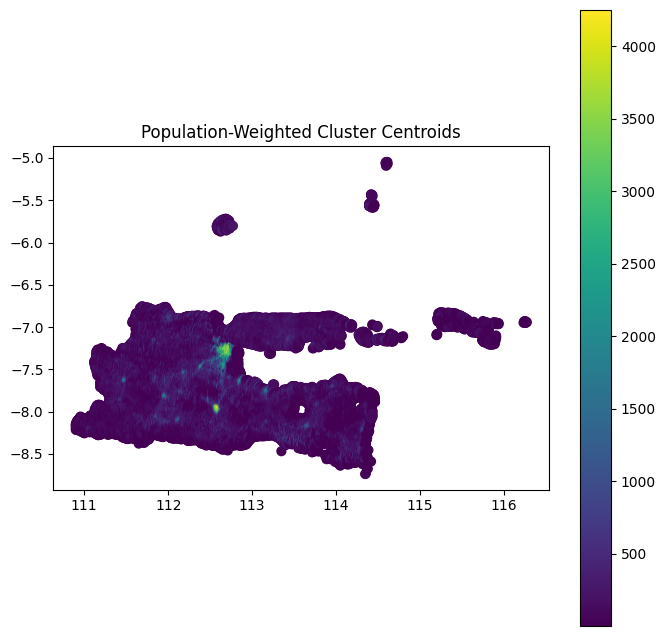

In [ ]:
# 9. Export for QGIS and further analysis
centroids_gdf.to_csv('file_path', index=False)
centroids_gdf.to_file('file_path')

# 10. Preview output table and quick plot ---
print(centroids_gdf[['cell_id', 'total_population', 'longitude', 'latitude']].head())

fig, ax = plt.subplots(figsize=(8, 8))
centroids_gdf.plot(ax=ax, column='total_population', cmap='viridis', legend=True, markersize=40)
ax.set_title("Population-Weighted Cluster Centroids")
plt.show()